In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os, sys, getpass
user = getpass.getuser()
sys.path.append(f'/home/{user}/codes/hpe_library')
#os.chdir('/home/hrai/codes/hpe_library')
from lib_import import *
from my_utils import *
motionbert_root = f'/home/{user}/codes/MotionBERT'
os.chdir(motionbert_root)

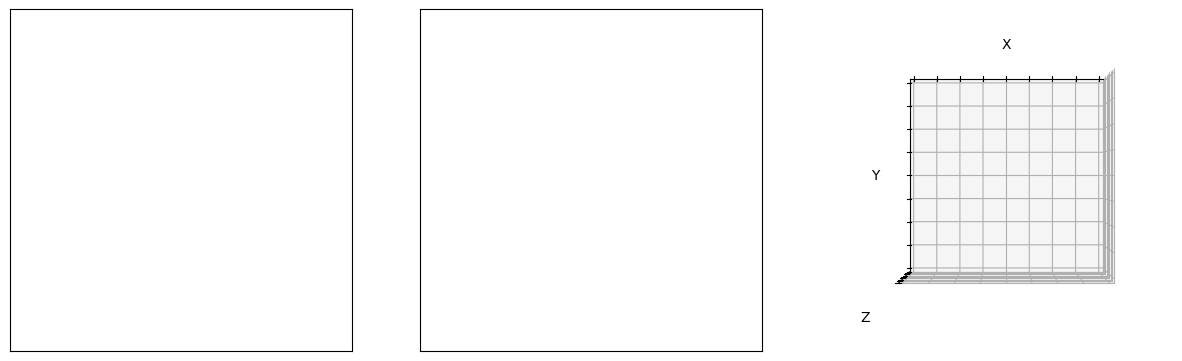

In [2]:
# initialize figure and plot function
import concurrent.futures

%matplotlib inline
fig = plt.figure(1, figsize=(15, 5))
fig.clear()
axd = fig.subplot_mosaic(
    """
    ABC
    """,
    per_subplot_kw={('C'): {'projection': '3d'}}
)

axA = axes_2d(ax=axd['A'], normalize=True, show_axis=False)
axB = axes_2d(ax=axd['B'], normalize=True, show_axis=False)
axC = axes_3d(ax=axd['C'], show_axis=False, view=(-90, -90))

def plot_frame(frame_num):
    cam_3d_from_canonical_3d = cam_3d_from_canonical_3d_list[frame_num]
    img_2d_from_canonical_3d = cam_3d_from_canonical_3d @ int_mat.T
    img_2d_from_canonical_3d /= img_2d_from_canonical_3d[:, 2:]
    img_2d = cam_3d_list[frame_num] @ int_mat.T
    img_2d /= img_2d[:, 2:]
    
    img_2d_norm = normalize_input(img_2d, W, H)
    img_2d_centered_norm = img_2d_norm - img_2d_norm[0]
    img_2d_from_canonical_3d_norm = normalize_input(img_2d_from_canonical_3d, W, H)
    canonical_center = img_2d_from_canonical_3d_norm[0]
    img_2d_from_canonical_3d_norm = img_2d_from_canonical_3d_norm - img_2d_from_canonical_3d_norm[0]
    
    clear_axes([axA, axB, axC])
    draw_2d_pose(axA, img_2d_norm, normalize=True, color='k')
    axA.axhline(0, 0, 1, color='k', linestyle='--', linewidth=0.5)
    axA.axvline(0, 0, 1, color='k', linestyle='--', linewidth=0.5)
    draw_2d_pose(axB, img_2d_centered_norm*sizeup, normalize=True, color='r', label='centered')
    draw_2d_pose(axB, img_2d_from_canonical_3d_norm*sizeup, normalize=True, color='b', label='canonical 3d (same z)')
    axB.plot(canonical_center[0]*sizeup, canonical_center[1]*sizeup, 'rx', markersize=5, label='canonical center')
    axB.axhline(0, 0, 1, color='k', linestyle='--', linewidth=0.5)
    axB.axvline(0, 0, 1, color='k', linestyle='--', linewidth=0.5)
    draw_3d_pose(axC, cam_3d_hat_list[frame_num]*sizeup)
    
    handles, labels = axB.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    leg = axB.legend(by_label.values(), by_label.keys())
    
    # 이미지를 메모리에 저장
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    
    #plt.close(fig)  # 메모리 누수 방지
    return image


In [39]:
dataset_list = []
dataset_list.append('h36m_gt_pkl')
dataset_list.append('fit3d_gt_pkl')
#dataset_list.append('3dhp_gt_test_pkl')
#dataset_list.append('3dhp_gt_train_pkl')

overwrite = True

for dataset in dataset_list:
    print(dataset)
    load_folder = f'/home/hrai/codes/MotionBERT/data/motion3d/{dataset}'

    #subject_list = ['s03']
    sizeup = 1.0
    axA.set_title('Original')
    axB.set_title(f'Canonical (x{sizeup})')
    axC.set_title(f'Cam 3d (x{sizeup})')
    

    pbar = tqdm(glob(load_folder + '/*.pkl'))
    for item in pbar:
        #print(item)
        splited = item.split('/')[-1].split('.')[0].split('_')
        subject = splited[0]
        
        if 'fit3d_gt_pkl' == dataset: 
            cam_id = splited[1]
            action = '_'.join(splited[2:])
            video_name = f'compare_input_type_{subject}_{action}_{cam_id}.mp4'
        elif 'h36m_gt_pkl' == dataset:
            cam_id = splited[1]
            action = splited[2]
            video_name = f'compare_input_type_{subject}_{action}_{cam_id}.mp4'
        elif dataset in ['3dhp_gt_test_pkl', '3dhp_gt_train_pkl']:
            video_name = f'compare_input_type_{subject}.mp4'
            
        
        #print(subject, action, cam_id)    
        #if subject not in subject_list: continue
        
        folder = f'/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/{dataset}/{subject}'
        if not os.path.exists(folder): os.makedirs(folder)
        filename = os.path.join(folder, video_name) 
        #print(filename)
        if not overwrite and os.path.exists(filename): 
            print(f'{filename} already exists')
            continue
        
        data = readpkl(item)
        if type(data['cam_param']) == list:
            cam_param = data['cam_param'][0].reshape(1)[0].copy()
        elif type(data['cam_param']) == dict:
            cam_param = data['cam_param']
        int_mat = cam_param['intrinsic']
        ext_mat = cam_param['extrinsic']
        cam_proj = int_mat @ ext_mat
        R = ext_mat[:3, :3]
        t = ext_mat[:3, 3]
        C = T_to_C(R, t)
        if 'h36m_gt_pkl' == dataset:
            W, H = 1000, 1000
        elif 'fit3d_gt_pkl' == dataset:
            W, H = 900, 900
        elif dataset in ['3dhp_gt_test_pkl', '3dhp_gt_train_pkl']:
            W, H = cam_param['W'], cam_param['H']
        num_frames = len(data['cam_3d'])
        cam_3d_list = np.array(data['cam_3d']).copy()/1000 # (F, J, 3)
        cam_3d_hat_list = get_rootrel_pose(cam_3d_list)
        cam_3d_from_canonical_3d_list = cam_3d_list.copy()
        cam_3d_from_canonical_3d_list[...,:2] -= cam_3d_list[:, 0:1, :2]
        
        
        with imageio.get_writer(filename, fps=6, macro_block_size=1) as writer:
            with concurrent.futures.ProcessPoolExecutor() as executor:
                for image in executor.map(plot_frame, range(0, num_frames, 5)):
                    writer.append_data(image)
            
        pbar.set_description(f'[{video_name}]')


h36m_gt_pkl


  0%|          | 0/836 [00:00<?, ?it/s]

[compare_input_type_S1_Greeting_58860488.mp4]: 100%|██████████| 836/836 [1:01:04<00:00,  4.38s/it]       


fit3d_gt_pkl


[compare_input_type_s08_warmup_6_50591643.mp4]: 100%|██████████| 1504/1504 [1:01:16<00:00,  2.44s/it]                       


In [37]:
data['cam_param']

[]